In [1]:
import cv2 as cv
import numpy as np
import torch
import random

from models.experimental import attempt_load
from utils.datasets import letterbox
from utils.general import check_img_size, check_requirements, check_imshow, non_max_suppression, apply_classifier, \
    scale_coords, xyxy2xywh, strip_optimizer, set_logging, increment_path
from utils.plots import plot_one_box
from utils.torch_utils import select_device, load_classifier, time_synchronized, TracedModel

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
device = torch.device("cuda:0")
model = attempt_load("best.pt", map_location=device)
_ = model.eval()
detect = model.model[-1]
dir(model.model[-1])
imgsz = 1280

Fusing layers... 
IDetect.fuse


/usr/local/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [3]:
nc = detect.nc
nl = detect.nl
no = detect.no
na = detect.na

anchor_grid = detect.anchor_grid.squeeze().tolist()
names = model.names
stride = model.stride
max_stride = int(stride.max())
print(f"nc:{nc} {names}")
print(f"nl:{nl} {stride} {max_stride}")
print(f"no:{no} XYWHC+Classes")

print(f"na:{na}", *anchor_grid, sep="\n")

colors = [[random.randint(0, 255) for _ in range(3)] for _ in names]

nc:1 ['blastHole']
nl:3 tensor([ 8., 16., 32.], device='cuda:0') 32
no:6 XYWHC+Classes
na:3
[[10.0, 13.0], [16.0, 30.0], [33.0, 23.0]]
[[30.0, 61.0], [62.0, 45.0], [59.0, 119.0]]
[[116.0, 90.0], [156.0, 198.0], [373.0, 326.0]]


(690, 1170, 3) -> (1280, 1280, 3)


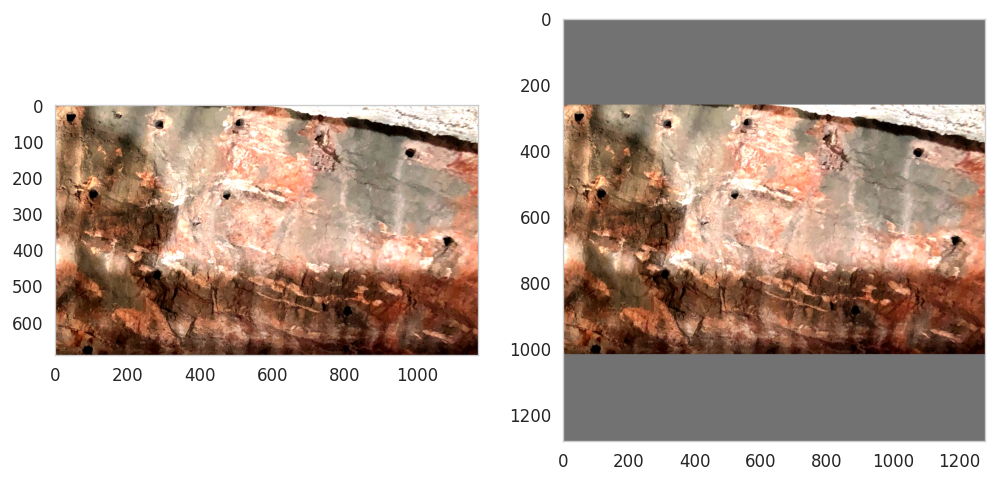

In [4]:
img = cv.imread("../datasets/images/train/bh_1001.png")
img0 = cv.cvtColor(img, cv.COLOR_BGR2RGB)
im0 = letterbox(img0, new_shape=(imgsz, imgsz), stride=max_stride, auto=False)[0]
print(img.shape,"->", im0.shape)

def plot_single_image(image, grid=0, call=False):
    plt.grid(grid)
    plt.imshow(image)
    if not call:
        plt.show()

def plot_multi_images(*images, grid=0):
    n = len(images)
    assert n, "Func needs at least 2 image as param!"
    row_colum = 100 + n * 10
    plt.figure(figsize=(5*n, 8),dpi=60)
    for i, image in enumerate(images):
        plt.subplot(row_colum + i + 1)
        plot_single_image(image, grid=grid, call=True)
    plt.show()

plot_multi_images(img0, im0)

In [5]:
conf_threshold = 0.3
iou_threshold = 0.6

im = im0.transpose(2,0,1) / 255.0
batch_in = torch.Tensor(im).to(device).float().unsqueeze(0)
out = model(batch_in, augment=False)[0]
pred = non_max_suppression(out, conf_threshold)
pred[0].shape

torch.Size([11, 6])

[30, 17, 62, 48] ind0:blastHole 91.71
[717, 76, 747, 105] ind0:blastHole 92.77
[461, 233, 494, 266] ind0:blastHole 93.11
[261, 450, 300, 489] ind0:blastHole 94.34
[274, 38, 304, 67] ind0:blastHole 94.79
[496, 33, 525, 63] ind0:blastHole 95.26
[73, 656, 107, 689] ind0:blastHole 97.93
[966, 112, 1001, 147] ind0:blastHole 98.71
[1071, 352, 1114, 396] ind0:blastHole 98.89
[787, 546, 826, 586] ind0:blastHole 98.94
[87, 228, 123, 264] ind0:blastHole 99.27


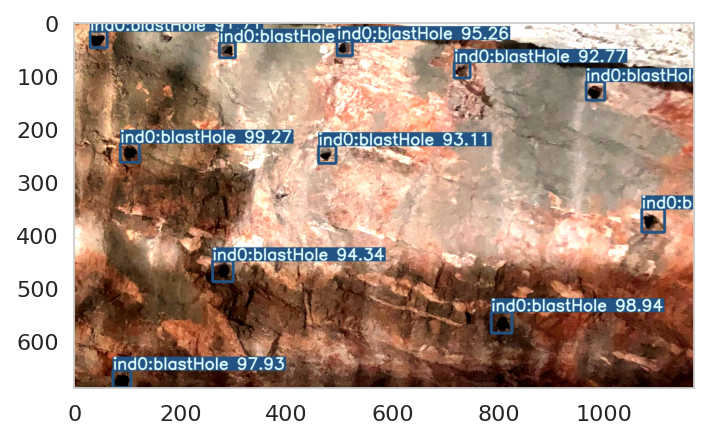

In [6]:
def plot_detect_src(prediction, batch_inputs, img_source, labels, title=None):
    det = torch.ones_like(prediction[0], device=device)
    det.copy_(prediction[0])
    det[:, :4] = scale_coords(batch_inputs.shape[2:], det[:, :4], img_source.shape).round()
    detect_img = img_source.copy()
    for *xyxy, conf, cls in reversed(det):
        c = int(cls)
        label = f'ind{c}:{labels[c]} {conf*100:.2f}'
        print([int(i.cpu().numpy()) for i in xyxy], label)
        plot_one_box(xyxy, detect_img, label=label, color=colors[int(cls)])

    plt.figure(figsize=(5, 5), dpi=80)
    if title is not None:
        plt.title(title)
    plot_single_image(detect_img)

plot_detect_src(pred, batch_in, img0, names)

[33, 281, 68, 315] ind0:blastHole 91.71
[785, 345, 817, 377] ind0:blastHole 92.77
[504, 518, 541, 554] ind0:blastHole 93.11
[286, 754, 328, 797] ind0:blastHole 94.34
[299, 304, 333, 336] ind0:blastHole 94.79
[543, 299, 575, 331] ind0:blastHole 95.26
[80, 980, 117, 1017] ind0:blastHole 97.93
[1057, 385, 1096, 423] ind0:blastHole 98.71
[1171, 648, 1219, 696] ind0:blastHole 98.89
[861, 860, 904, 903] ind0:blastHole 98.94
[96, 511, 135, 551] ind0:blastHole 99.27


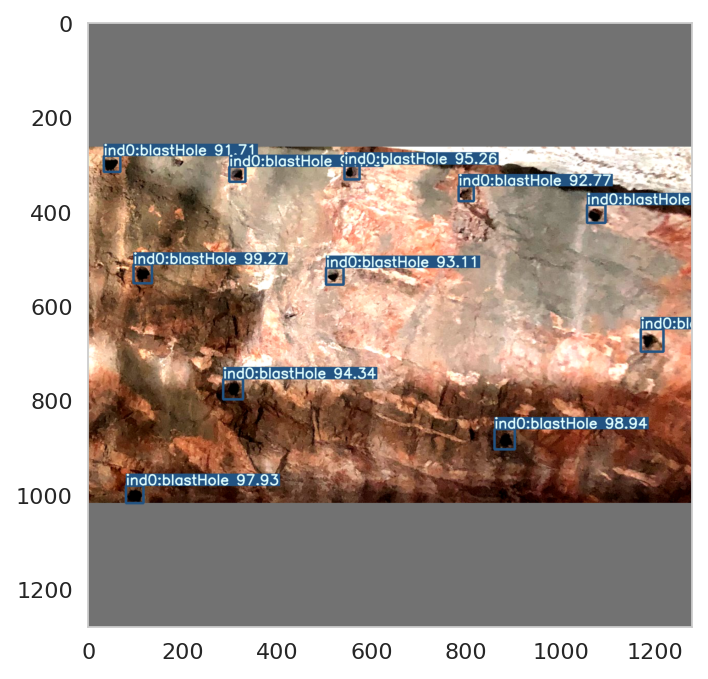

In [7]:
plot_detect_src(pred, batch_in, im0, names)

Head:3 Anchors:3 Number of Classes:1
Grid size: [160, 80, 40]
Slice size: [76800, 19200, 4800]  -> Sum = 100800
Output size 100800
[0, 76800, 96000, 100800]
torch.Size([76800, 6]) --> [3, 160, 160, 6]
torch.Size([19200, 6]) --> [3, 80, 80, 6]
torch.Size([4800, 6]) --> [3, 40, 40, 6]
3 Heads: torch.Size([3, 6, 160, 160]) torch.Size([3, 6, 80, 80]) torch.Size([3, 6, 40, 40])


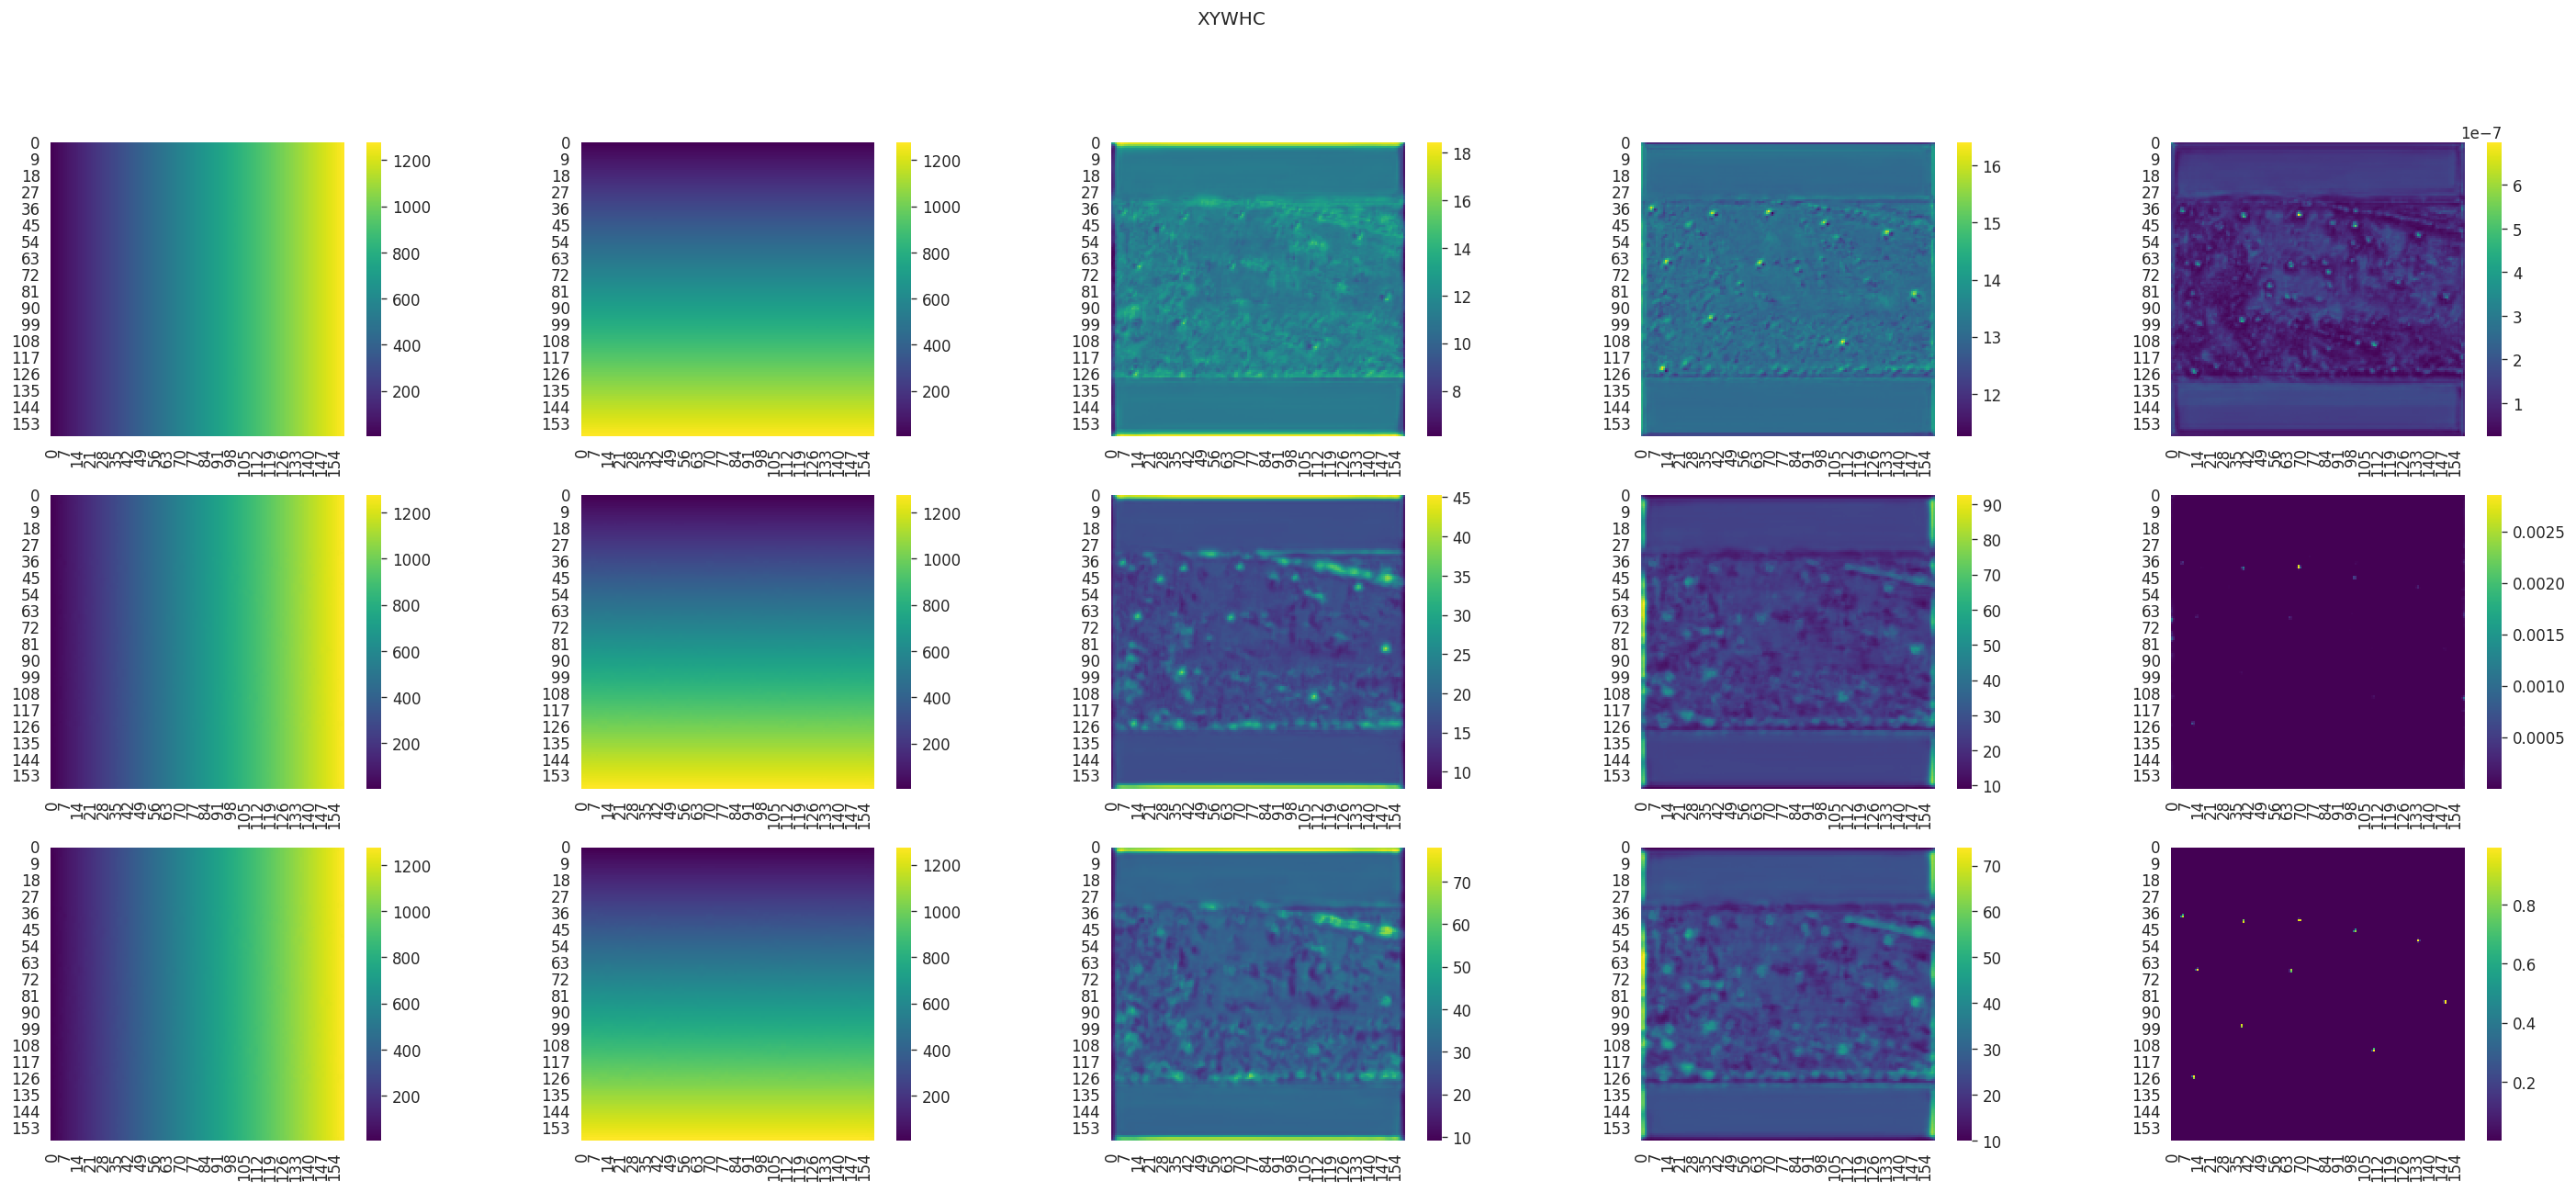

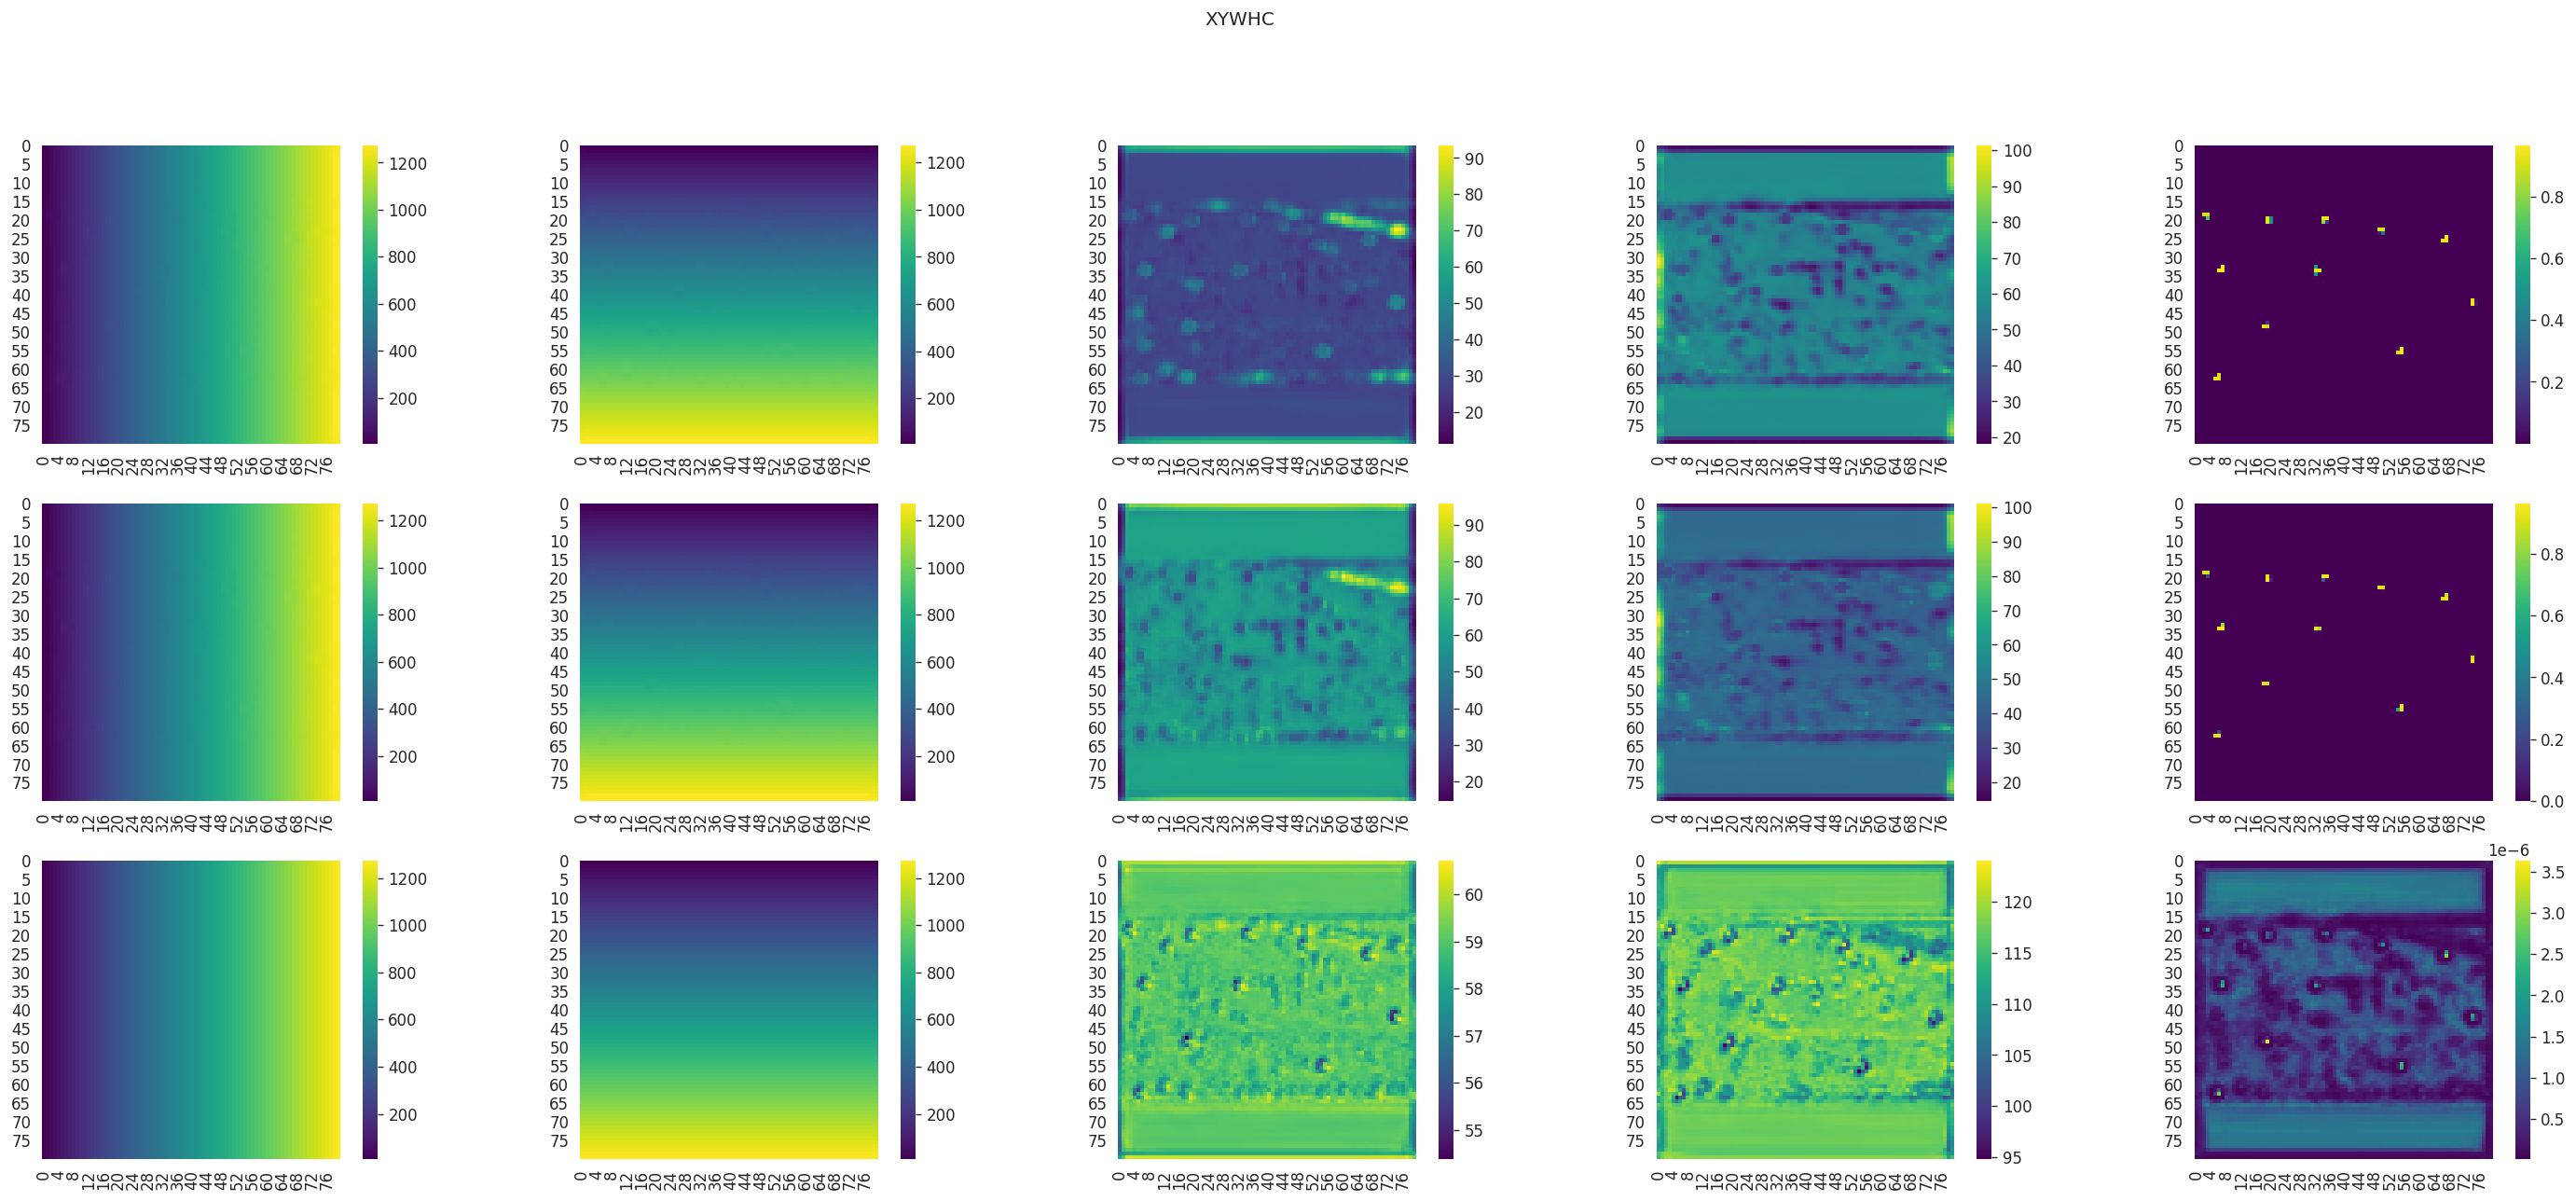

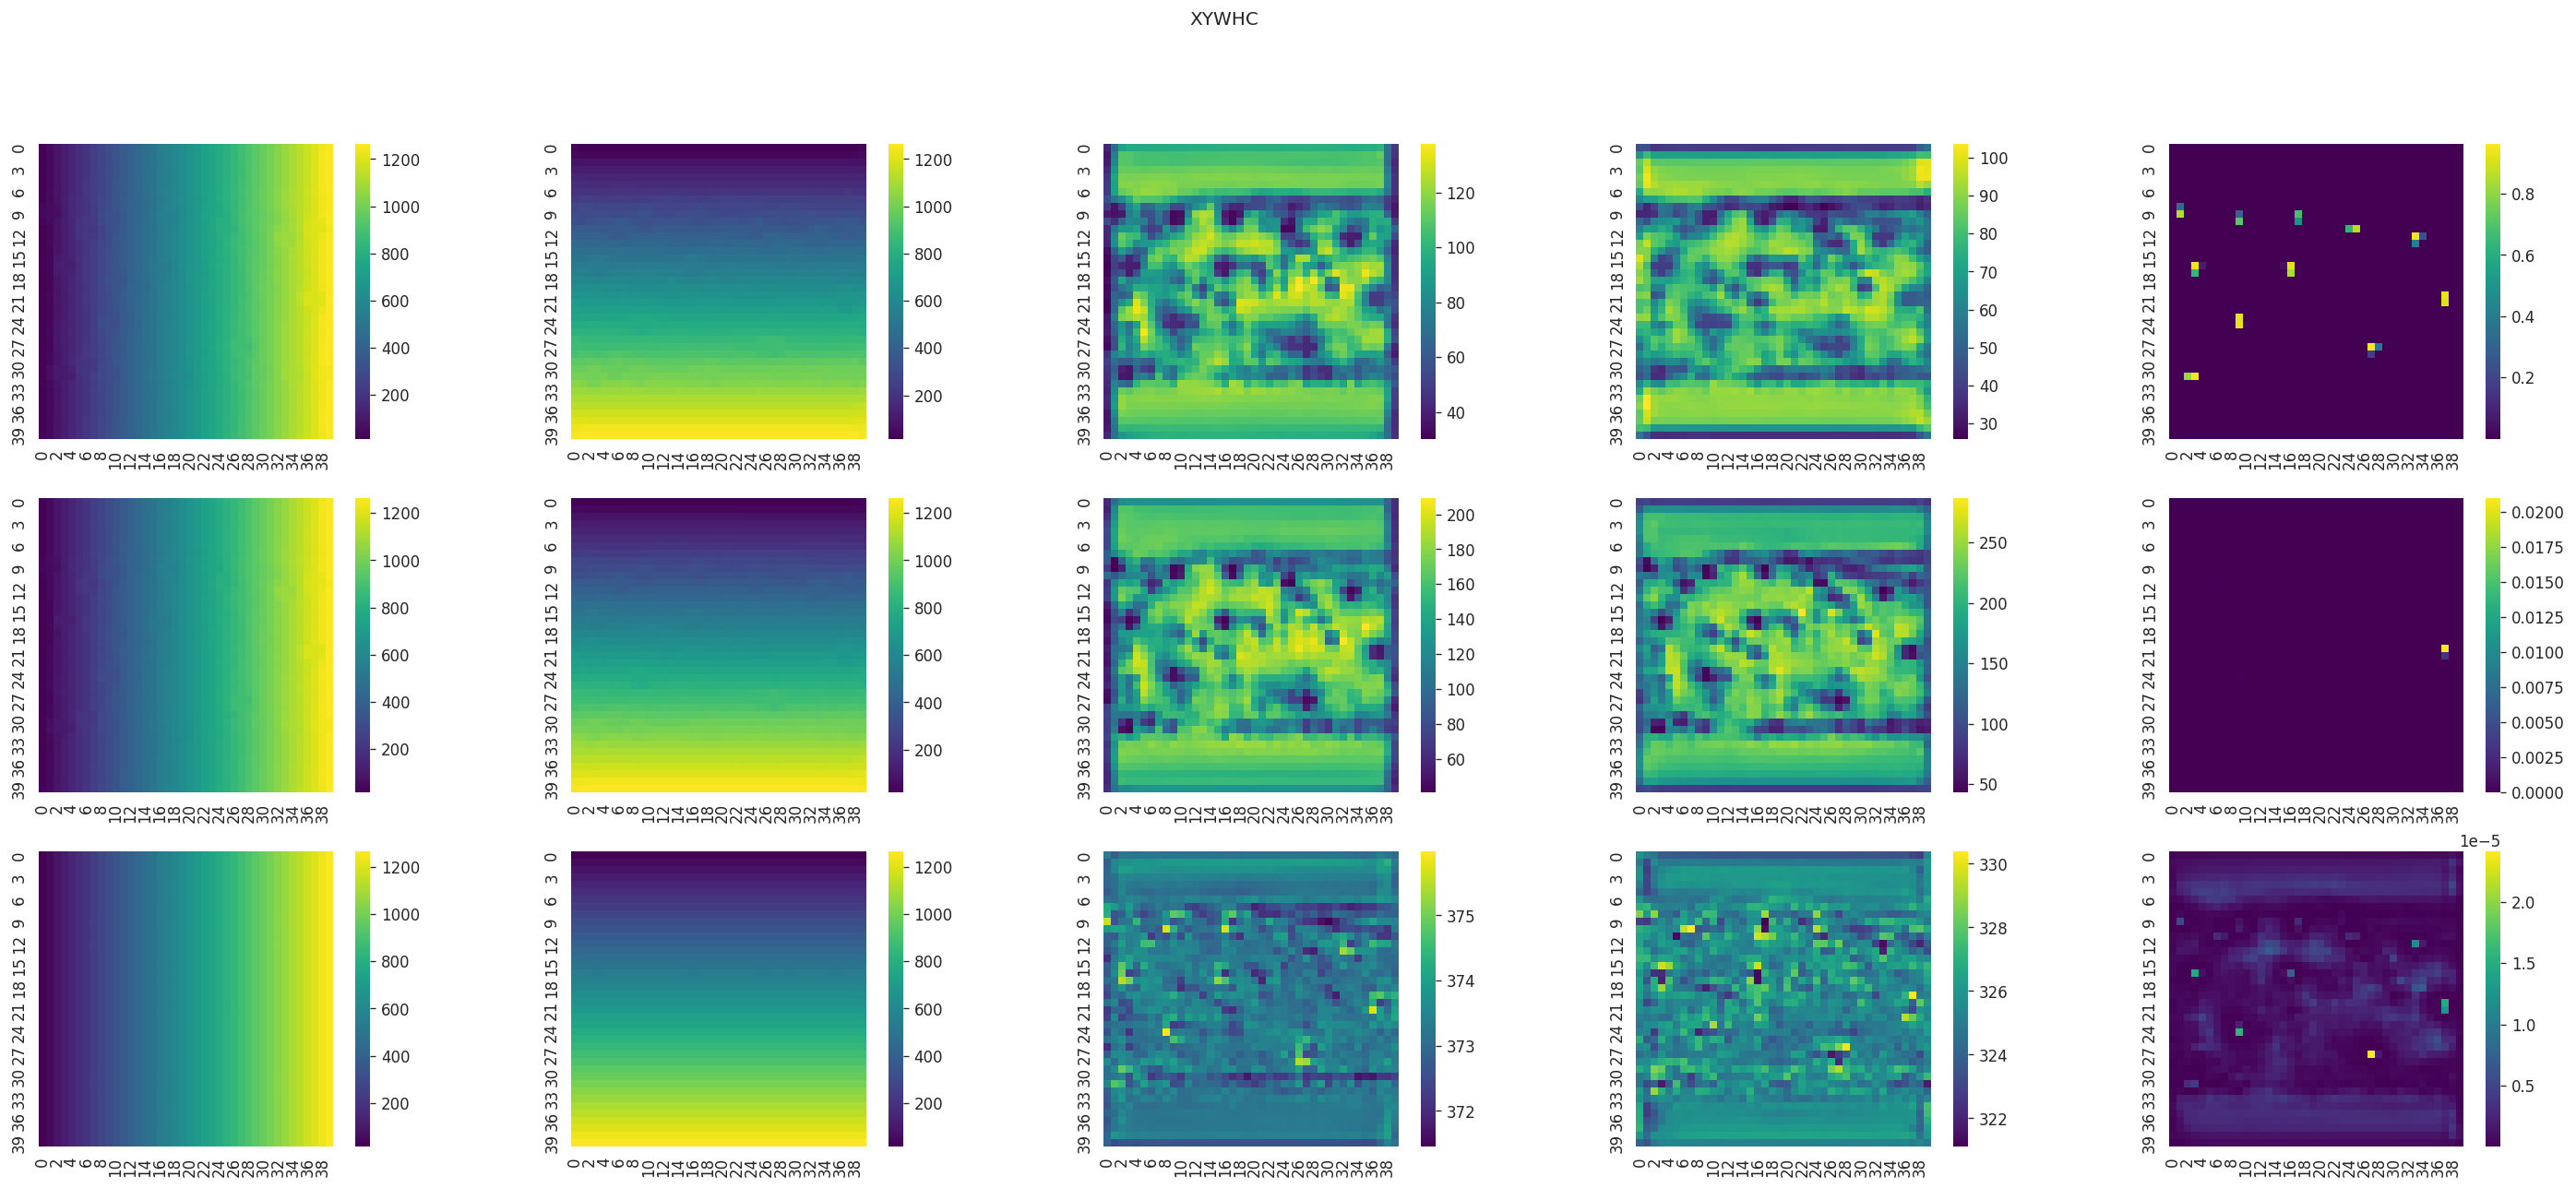

In [8]:
nb, channels, height, width = batch_in.shape
assert nc == out.shape[2]-5, f'Number of Classes({nc}) Does NOT Match with output size!'

detect_grid_size = [(imgsz // max_stride) * 2 ** i for i in range(nl)]
detect_grid_size.reverse()
slice_size = [i ** 2 * na for i in detect_grid_size]

print(f"Head:{nl}", f"Anchors:{na}", f"Number of Classes:{nc}")
print("Grid size:", detect_grid_size)
print("Slice size:", slice_size, " -> Sum =", sum(slice_size))
print("Output size", out.shape[1])
assert sum(slice_size) == out.shape[1]

slice_index = [0]
for i in slice_size:
    slice_index.append(i + slice_index[-1])
print(slice_index)
head = []
for i in range(len(slice_index) - 1):
    layer = out[:, slice_index[i]:slice_index[i+1], :].squeeze()
    new_shape = [na, detect_grid_size[i], detect_grid_size[i], no]
    print(layer.shape[:], "-->", new_shape)
    layer = layer.reshape(new_shape)
    head.append(layer.permute(0, 3, 1, 2))
print(len(head), "Heads:", *(i.shape for i in head))

def plot_single_heatmap(array, cmap='viridis', title=None, dpi=60):
    plt.figure(figsize=(5, 5), dpi=dpi)
    if title:
        plt.title(title)
    if isinstance(array, torch.Tensor):
        array = array.cpu().numpy()
    sns.heatmap(array, square=True, cmap=cmap)


def plot_multi_heatmap(*arrays, cmap='viridis', title=None, row=None, col=None):
    n = len(arrays)
    if row is not None:
        col = int(np.ceil(n / row))
    else:
        if col is not None:
            row = int(np.ceil(n / col))
        else:
            row = int(np.sqrt(n))
            col = int(np.ceil(n / row))

    fig, ax = plt.subplots(row, col, figsize=(6*col, 4*row), dpi = 60)
    if title is not None: fig.suptitle(title)

    for i, array in enumerate(arrays):
        if isinstance(array, torch.Tensor):
            array = array.cpu().numpy()
        r = i // col
        c = i % col
        axi = ax[r, c] if row > 1 else ax[c]
        sns.heatmap(array, square=True, cmap=cmap, ax=axi)
    plt.show()

for head_index in range(nl):
    plot_multi_heatmap(*(head[head_index][i,j] for i in range(na) for j in range(5)), title="XYWHC")

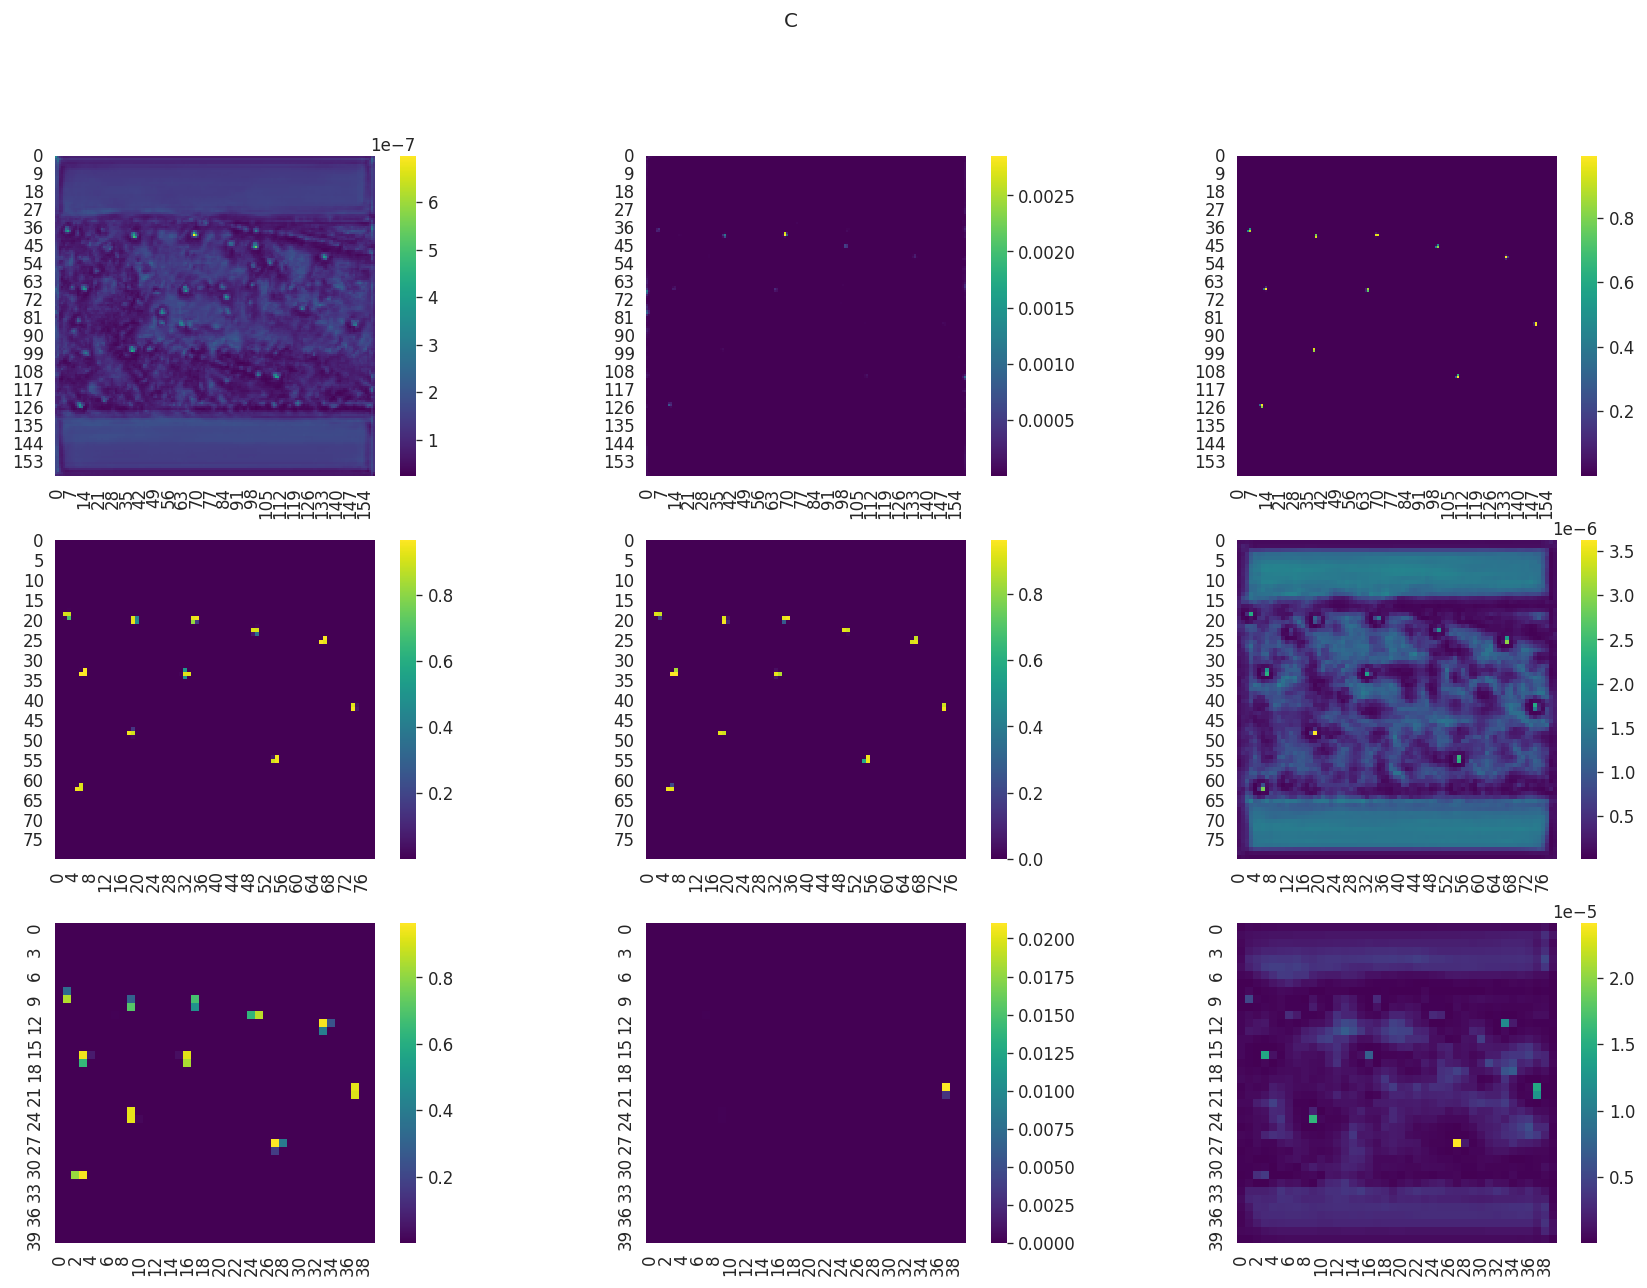

In [9]:
plot_multi_heatmap(*(head[i][j,4] for i in range(nl) for j in range(na)), col=na, title="C")

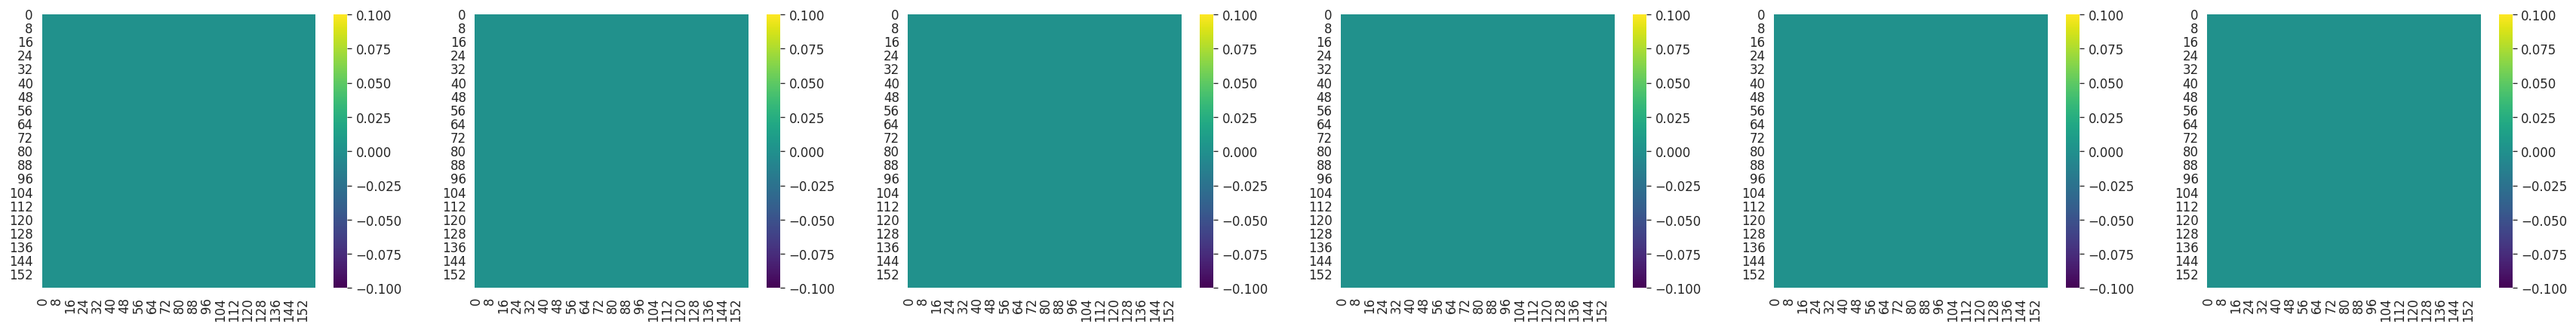

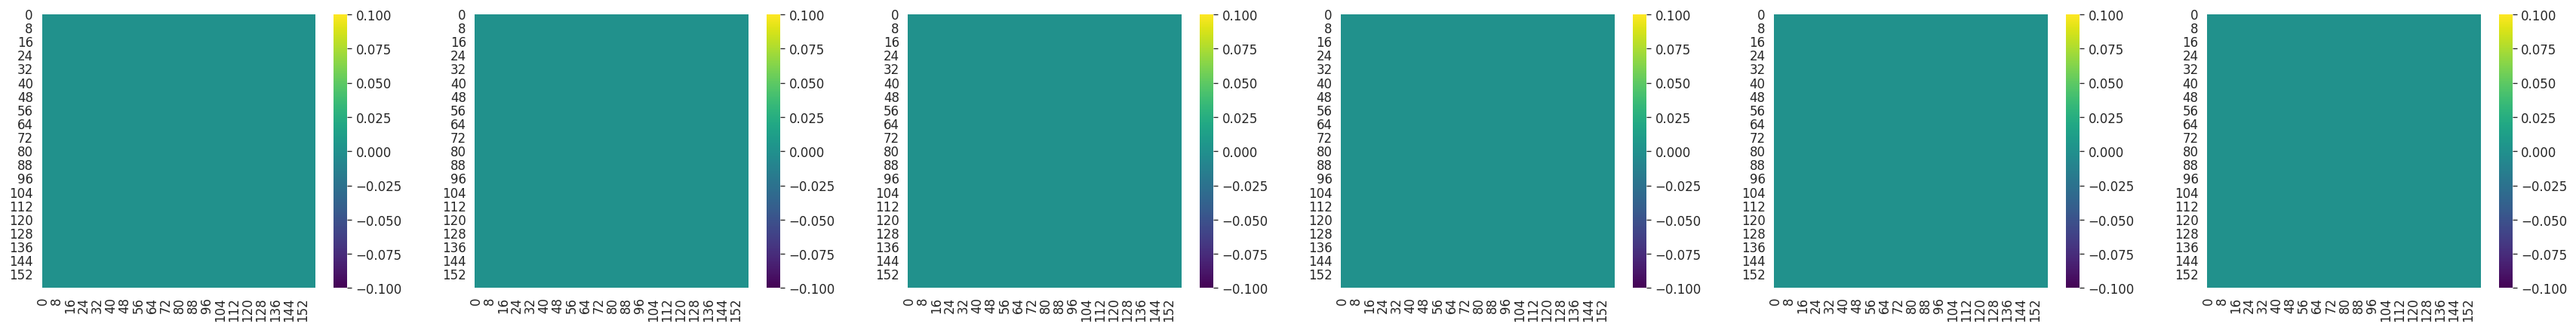

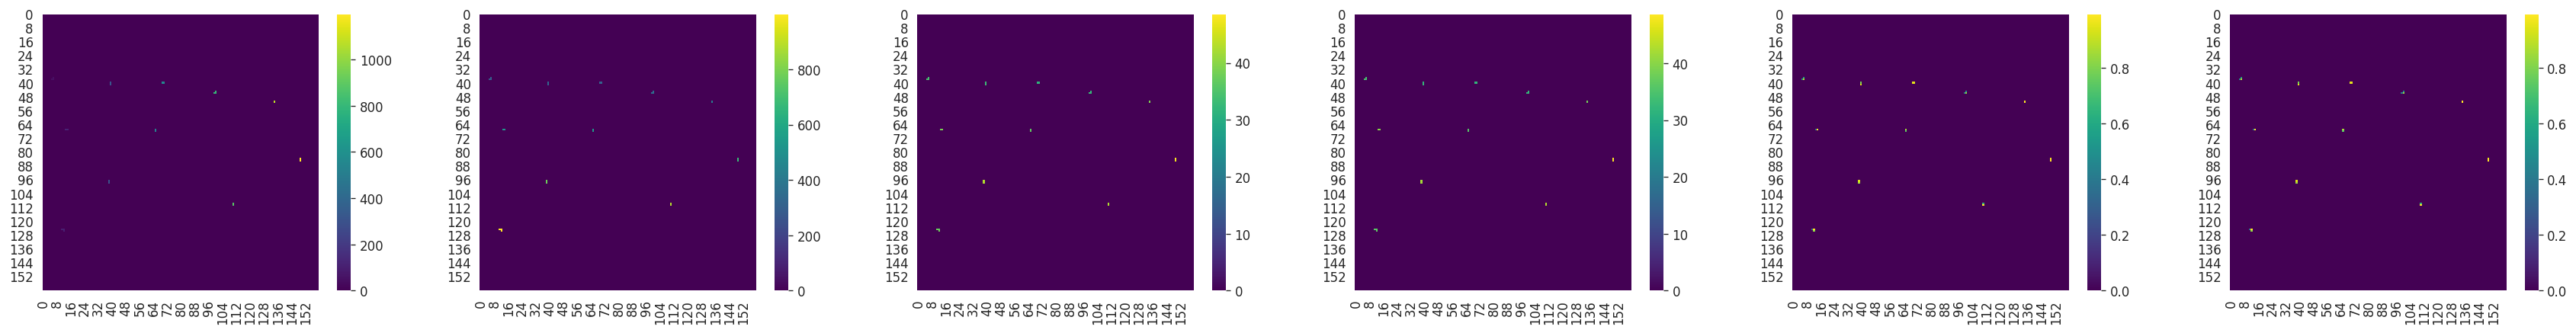

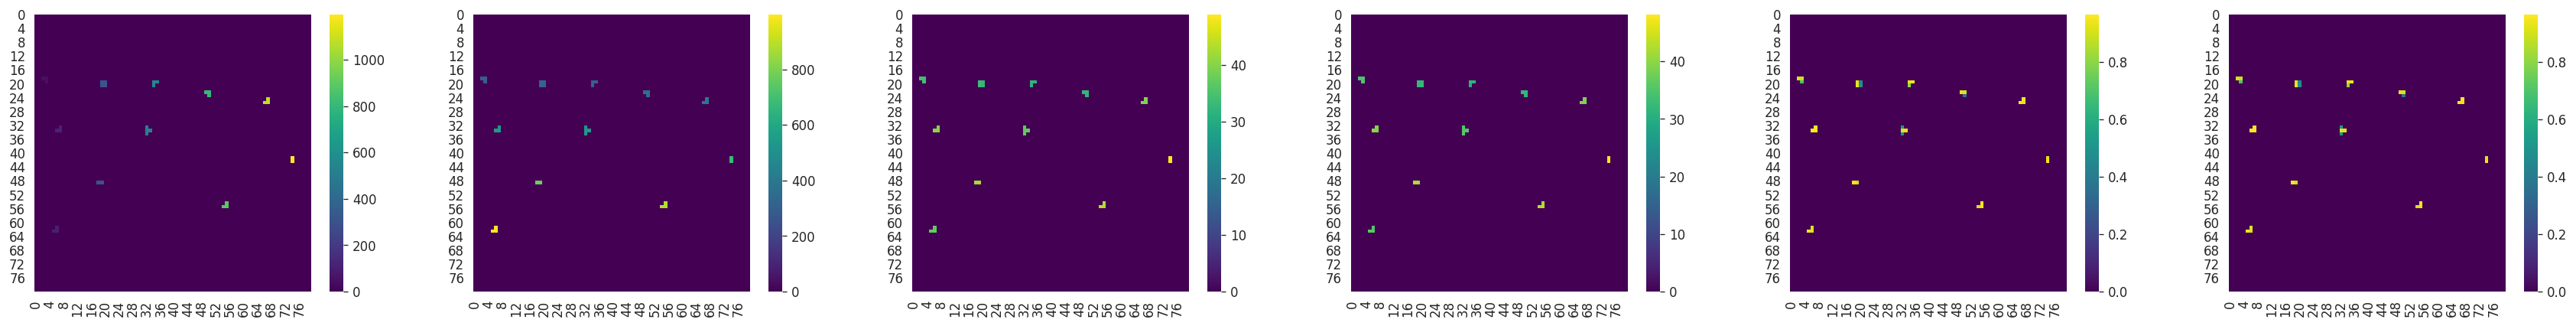

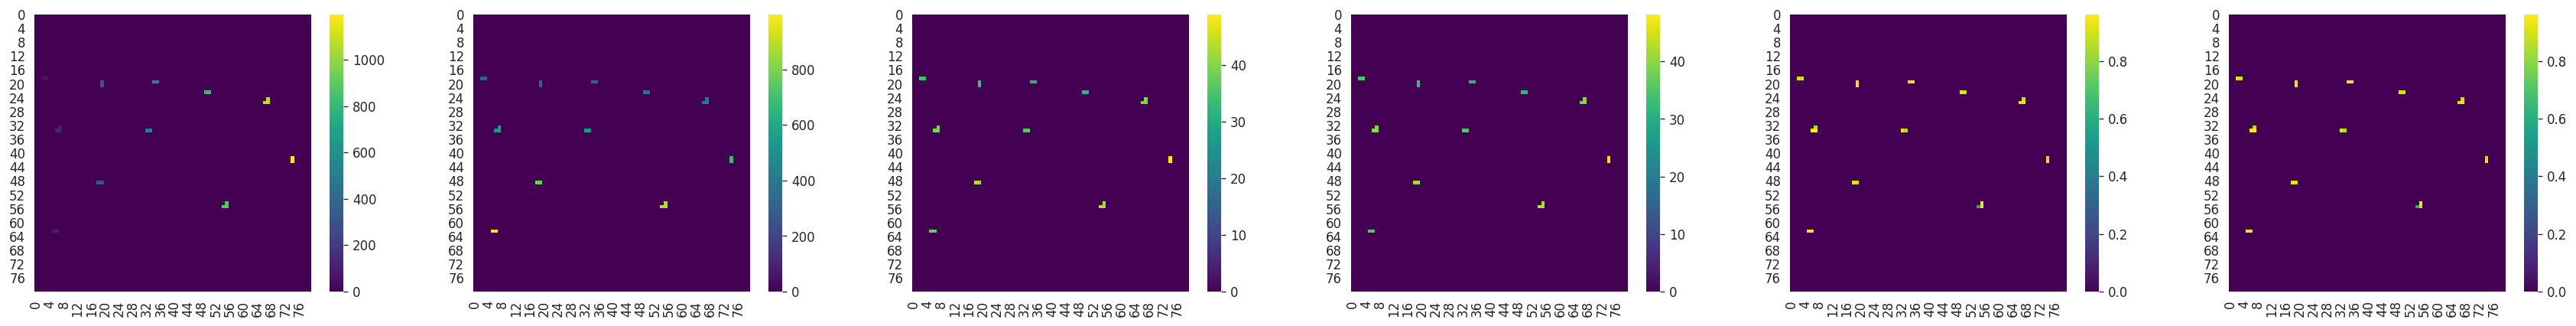

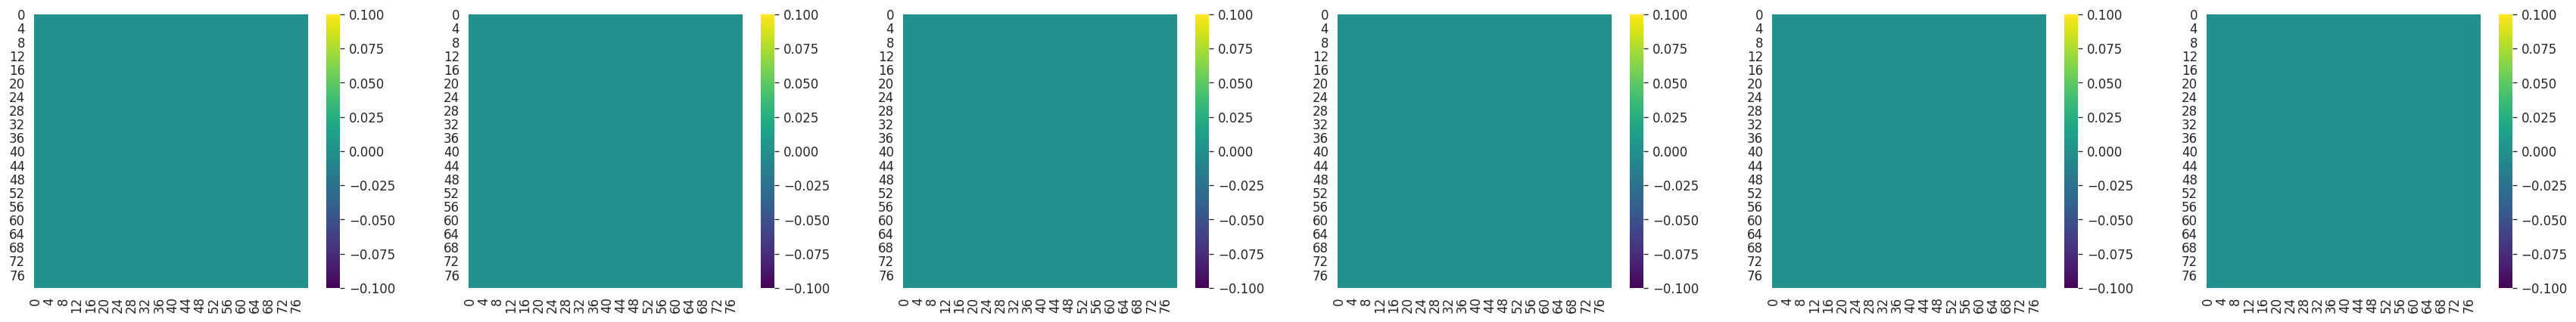

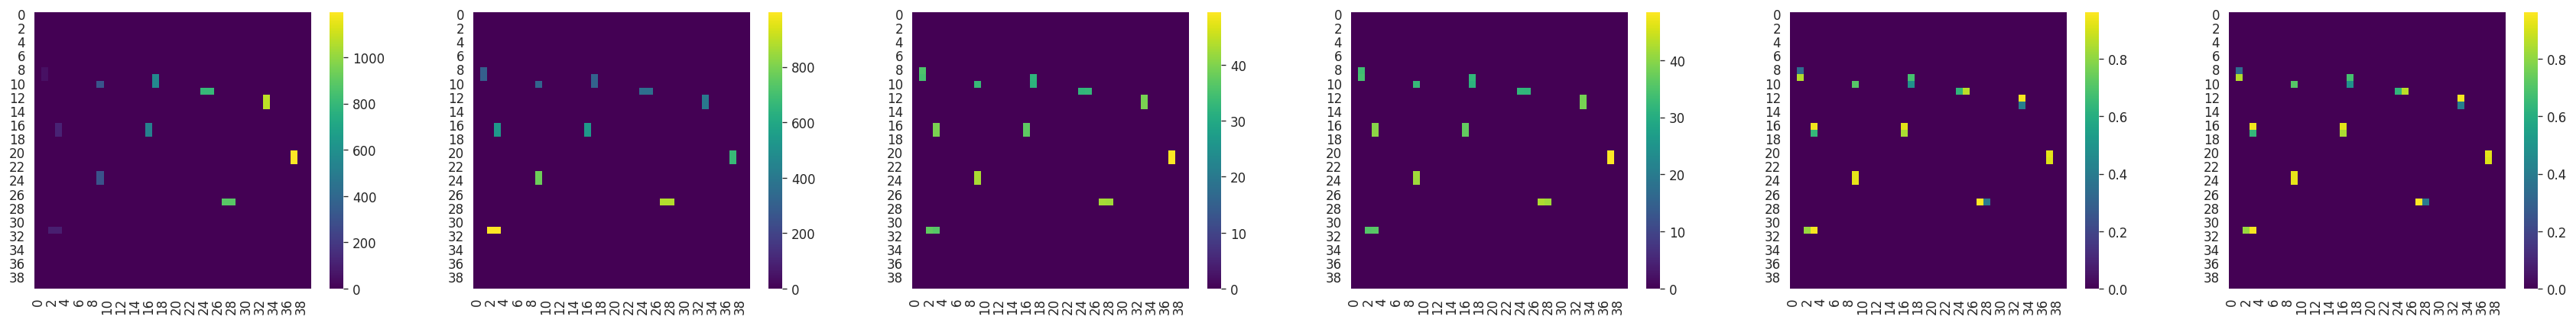

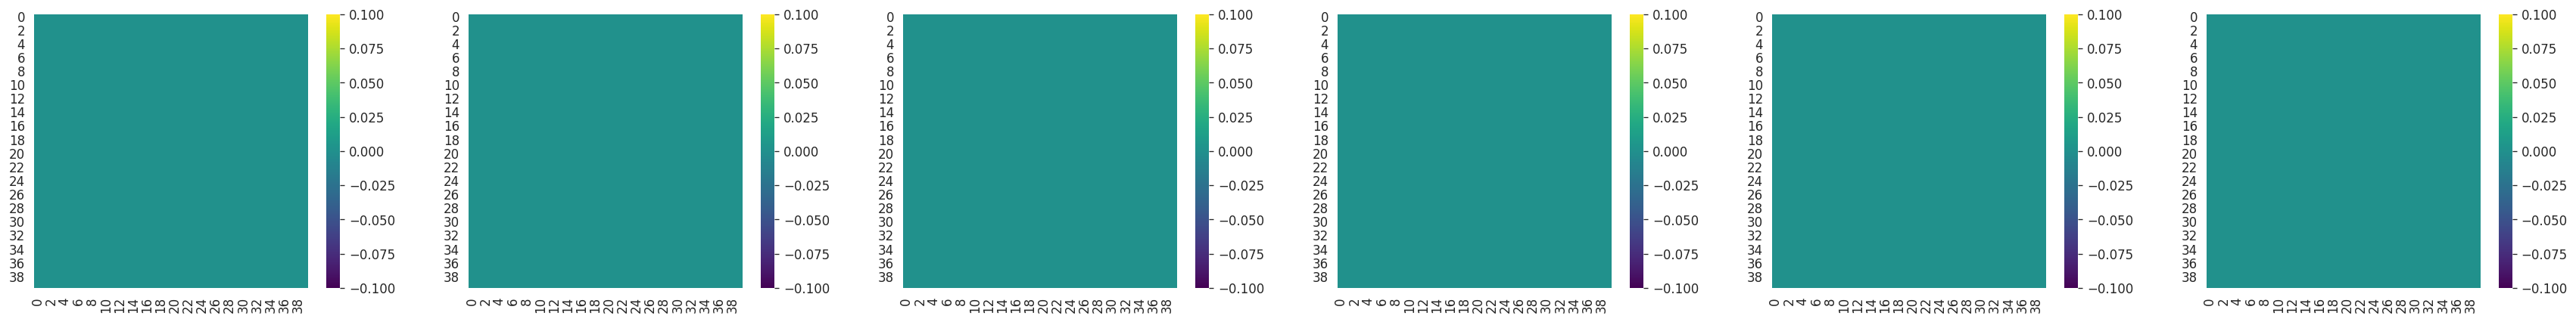

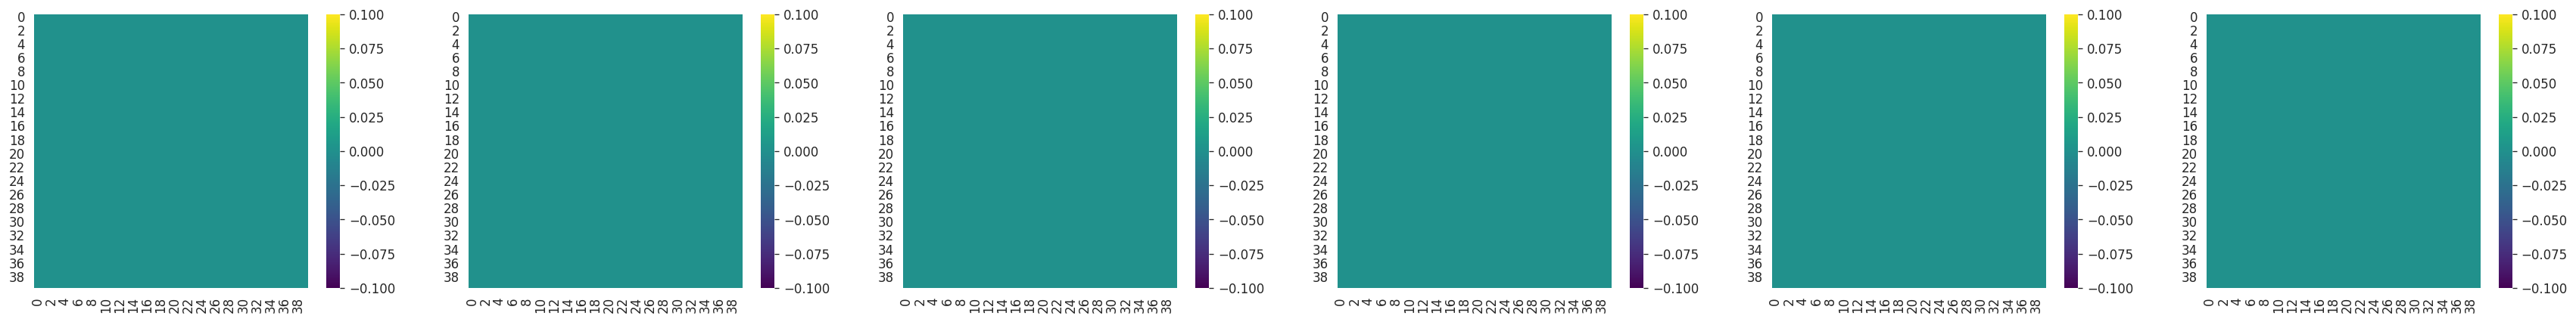

In [10]:
conf = [head[i][:, 4] for i in range(nl)]

pr_filt = []
for i in range(nl):
    y = [torch.where(conf[i][j] < conf_threshold, 0, head[i][j]) for j in range(na)]
    filt_head = torch.ones([na] + list(y[0].shape), dtype=torch.float32, device=device)
    for j in range(na):
        filt_head[j] = y[j]
    pr_filt.append(filt_head)

for i in range(nl):
    pr_filt[i][pr_filt[i] < 0.01] = 0
    for j in range(na):
        if nc == 1:
            pr_filt[i][j, 5:] = pr_filt[i][j, 4]
        else:
            pr_filt[i][j, 5:] *= pr_filt[i][j, 4]
        plot_multi_heatmap(*(pr_filt[i][j, k] for k in range(6)), col = 6)

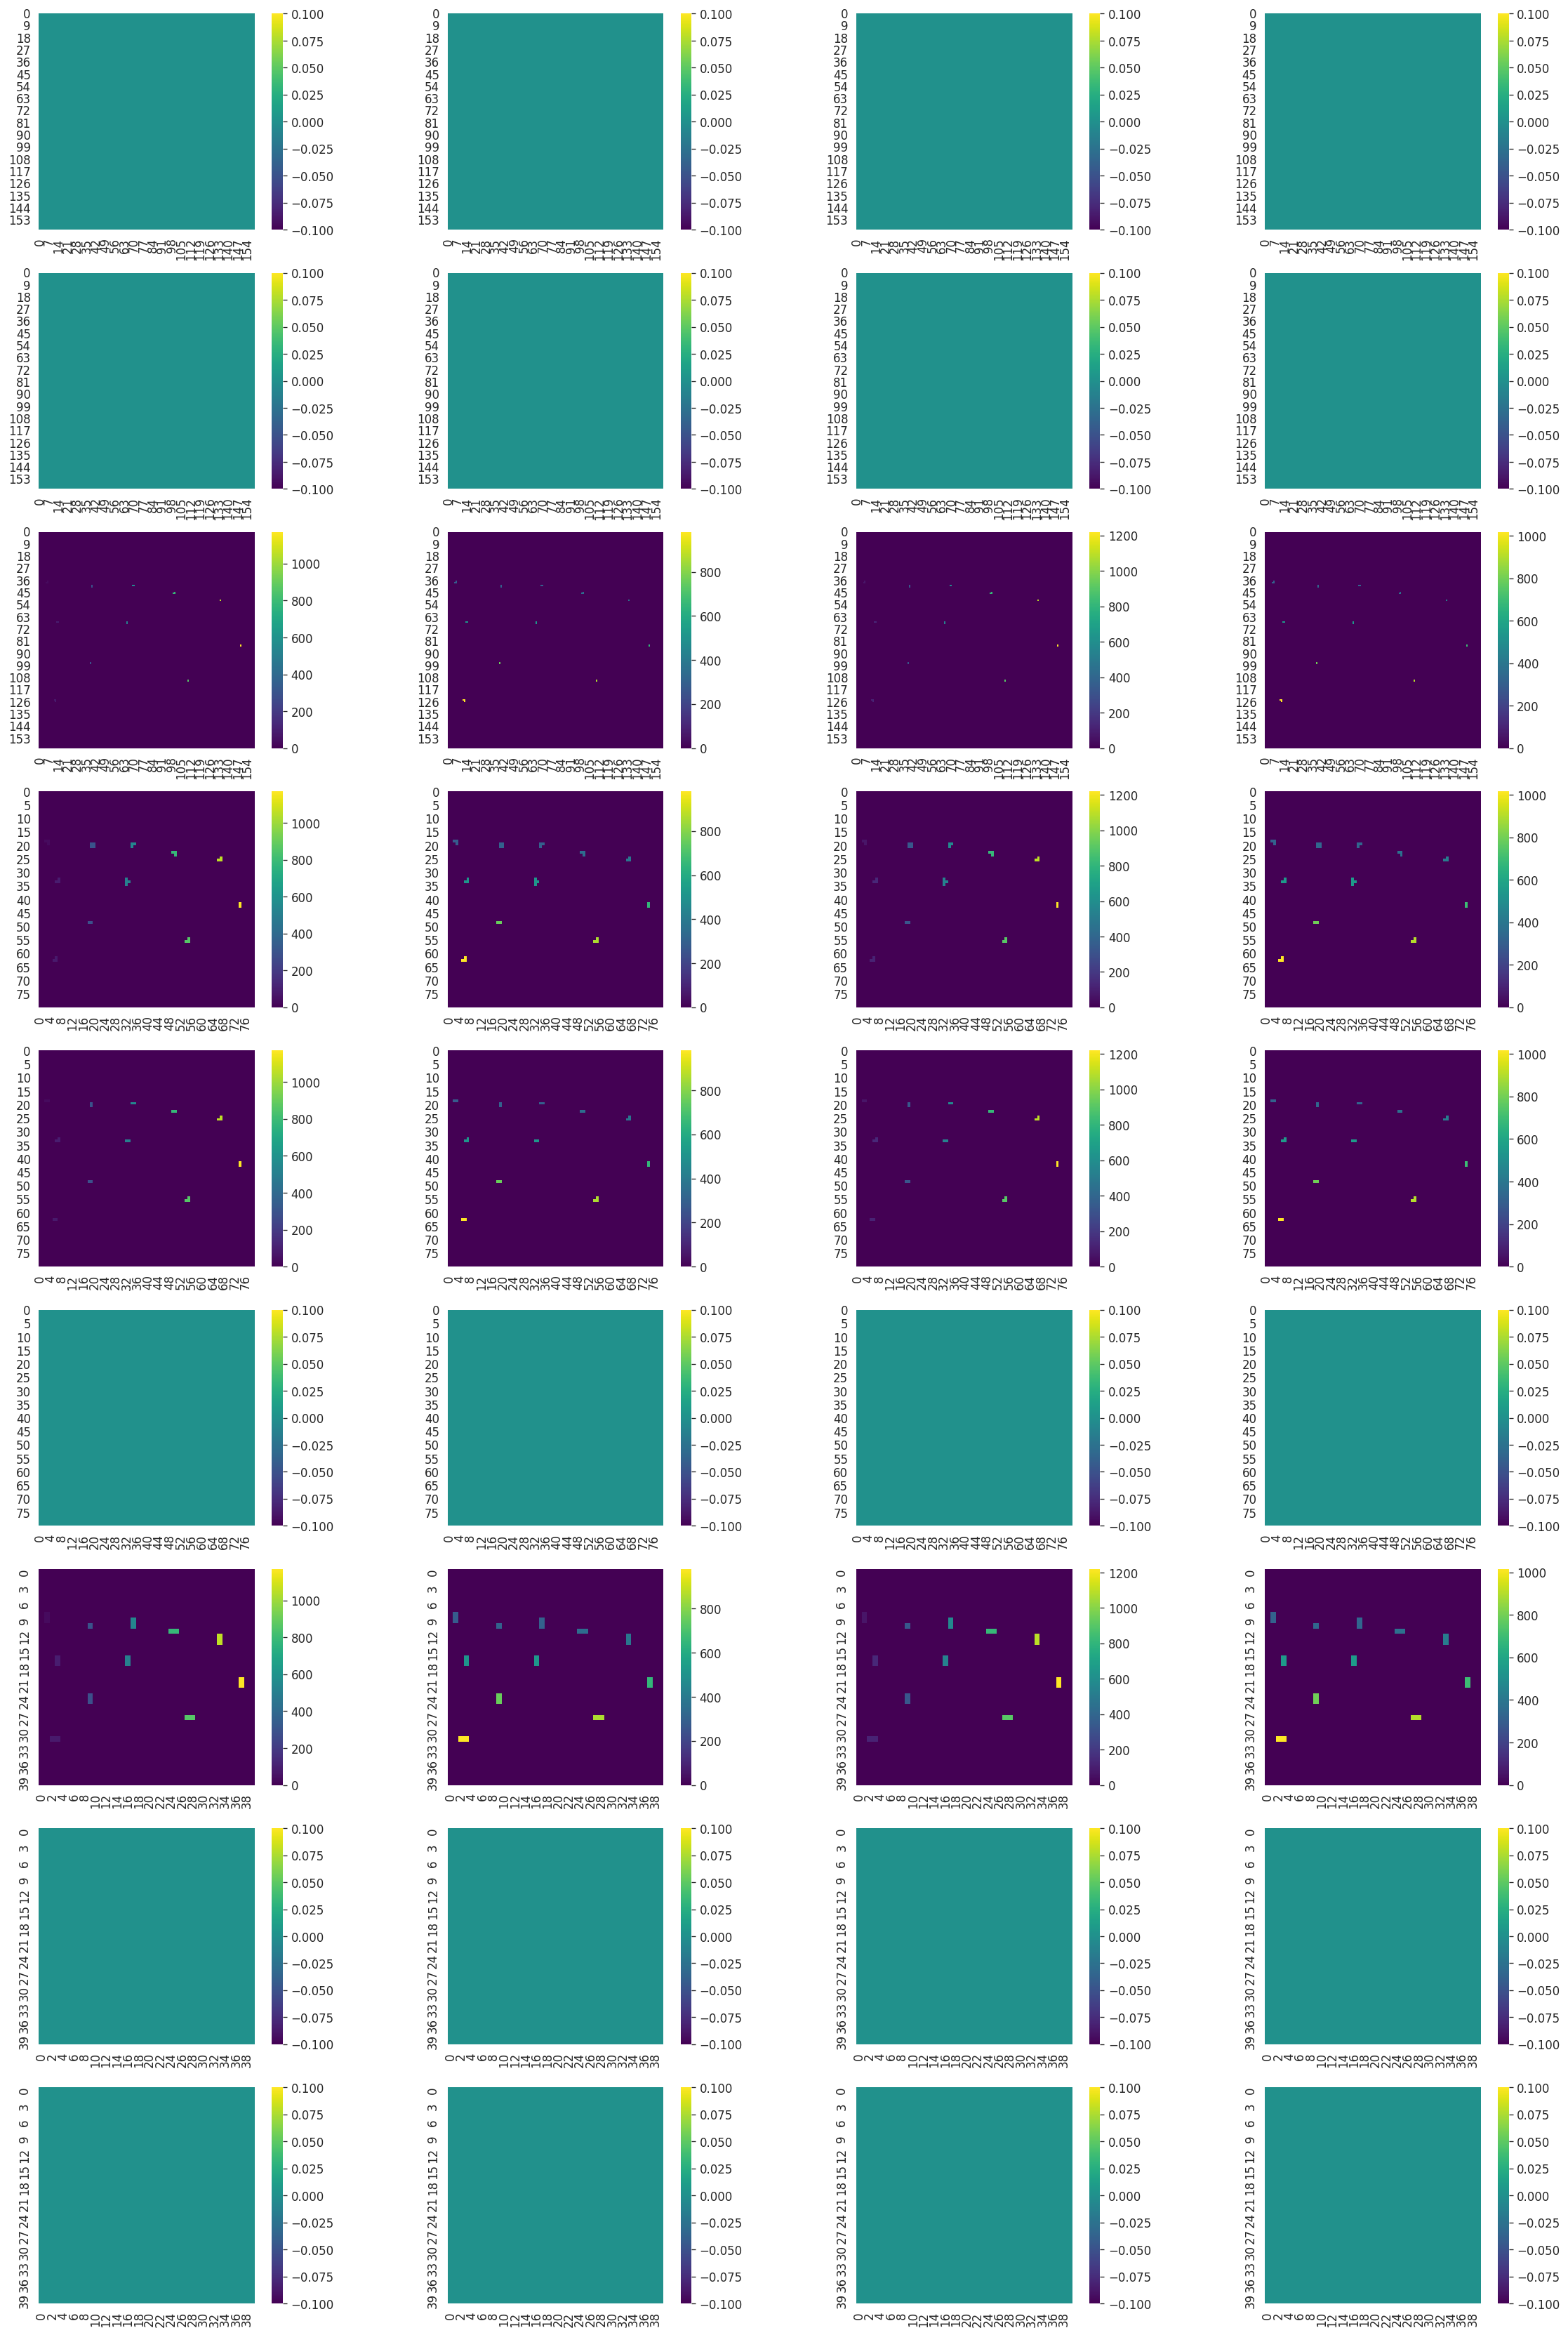

In [11]:
def xywh2xyxy(x):
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[:, 0, ...] = x[:, 0, ...] - x[:, 2, ...] / 2 # top left x
    y[:, 1, ...] = x[:, 1, ...] - x[:, 3, ...] / 2 # top left y
    y[:, 2, ...] = x[:, 0, ...] + x[:, 2, ...] / 2 # bottom right x
    y[:, 3, ...] = x[:, 1, ...] + x[:, 3, ...] / 2 # bottom right y
    return y
box = [xywh2xyxy(pr_filt[i][:, :4]) for i in range(nl)]
plot_multi_heatmap(*(box[i][j, k] for i in range(nl) for j in range(na) for k in range(4)), col=4)

In [12]:
cls_filt = list(pr_filt[i][:, 5:] for i in range(nl))
xyxycc = []
for i in range(nl):
    a, cls, gy, gx = torch.where(cls_filt[i] > conf_threshold)
    print(i)
    pr = cls_filt[i][a, cls, gy, gx]
    if len(pr):
        cls_filt[i] = torch.vstack([a, cls, gy, gx]).permute(1,0)
        xyxy = box[i][a, :4, gy, gx]
        xyxy = torch.hstack((xyxy, cls.view(-1,1), pr.view(-1,1)))
        print(xyxy.shape)
        xyxycc.append(xyxy)

xyxycc = torch.vstack(xyxycc)
xyxycc = xyxycc[torch.argsort(xyxycc[:, -1], descending=True)].cpu().numpy()
print(xyxycc)

0
torch.Size([24, 6])
1
torch.Size([58, 6])
2
torch.Size([21, 6])
[[     95.515      511.48      134.71      551.29           0     0.99268]
 [     861.43      860.14       904.1      903.39           0     0.98942]
 [     1171.2         648      1218.7      696.05           0     0.98888]
 [     1056.7      384.78      1095.6      422.94           0     0.98711]
 [     80.074      980.31      116.98      1016.6           0     0.97931]
 [     1170.3      647.82      1218.8       696.4           0     0.97477]
 [     94.989      511.82      135.35      551.59           0     0.96601]
 [     861.37      860.38      904.13      902.93           0     0.96304]
 [     94.864      512.33         135      551.48           0     0.96226]
 [     95.685      511.55      134.55      551.18           0     0.96226]
 [      94.86      511.81      135.06      551.05           0     0.96039]
 [     1056.7      384.51      1096.2      423.36           0     0.95836]
 [     95.365      511.48      135

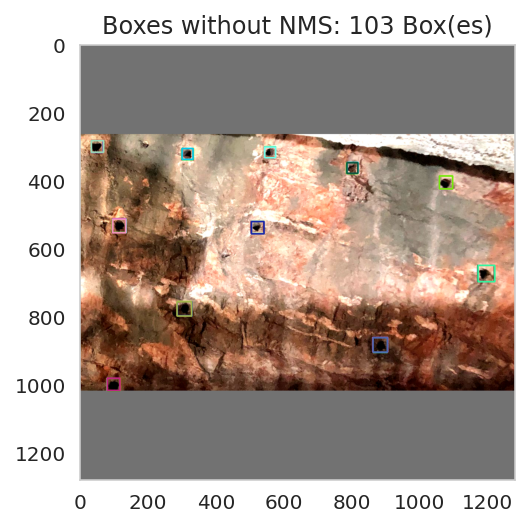

In [13]:
im1 = im0.copy()

for x1, y1, x2, y2 in xyxycc.round().astype(np.uint16)[..., :4]:
    cv.rectangle(im1, (x1, y1), (x2, y2), color=tuple(random.randint(0,255) for _ in range(3)) , thickness=4)

plt.title(f"Boxes without NMS: {xyxycc.shape[0]} Box(es)")
plot_single_image(im1)

In [14]:
def compute_area(x1y1x2y2):
    x1, y1, x2, y2 = x1y1x2y2.astype(np.float64)[:4]
    return (x2 - x1) * (y2 - y1)

def compute_intersection(xa1, xa2, xb1, xb2):
    assert xa1 <= xa2 and xb1 <= xb2, "x1 must <= x2"
    if xa1 > xb1:
        return compute_intersection(xb1, xb2, xa1, xa2)
    return min(max(xa2 - xb1, 0), xb2 - xb1)

def compute_iou(xyxy1, xyxy2):
    area_1, area_2 = compute_area(xyxy1), compute_area(xyxy2)
    x11, y11, x12, y12 = xyxy1.astype(np.float64)[:4]
    x21, y21, x22, y22 = xyxy2.astype(np.float64)[:4]

    x_in = compute_intersection(x11, x12, x21, x22)
    y_in = compute_intersection(y11, y12, y21, y22)
    area_intersection = x_in * y_in

    return area_intersection / (area_1 + area_2 - area_intersection)

def compute_diou(xyxy1, xyxy2):
    x11, y11, x12, y12 = xyxy1.astype(np.float64)[:4]
    x21, y21, x22, y22 = xyxy2.astype(np.float64)[:4]
    x_min, x_max = min(x11, x12), max(x12, x22)
    y_min, y_max = min(y11, y12), max(y12, y22)

    distance_p2 = ((x11 + x12 - x21 - x22) ** 2 + (y11 + y12 - y21 - y22) ** 2) / 4
    distance_c2 = (x_max - x_min) ** 2 + (y_max - y_min) ** 2

    return compute_iou(xyxy1, xyxy2) - distance_p2 / distance_c2

def nms(xyxy):
    from collections import deque
    stack = deque([0])
    keep = np.zeros(xyxy.shape[0], dtype=np.int8)
    keep[0] = 1
    while len(stack):
        k = stack.popleft()
        if keep[k] < 0:
            continue

        for j in np.where(keep[k+1:] >= 0)[0]:
            k0 = k + 1 + j
            # print(k, k0)
            if compute_iou(xyxy[k], xyxy[k0]) > iou_threshold:
                keep[k0] = -1
            else:
                stack.append(k0)
                keep[k0] = 1

        nms_xyxyc = xyxy[np.where(keep > 0)]

    return nms_xyxyc

nms_xyxyc = nms(xyxycc)

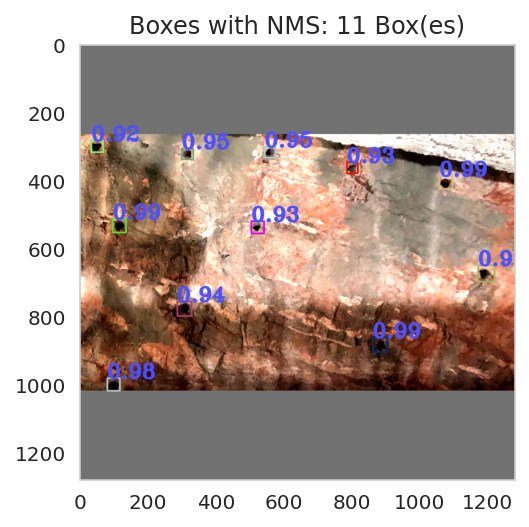

In [15]:
im1 = im0.copy()

for i in nms_xyxyc:
    x1, y1, x2, y2 = i[..., :4].round().astype(np.uint16)
    c = i[..., 4:]
    cv.rectangle(im1, (x1, y1), (x2, y2), color=tuple(random.randint(0,255) for _ in range(3)) , thickness=4)
    cv.putText(im1, f"{c[1]:.2f}", (x1,y1) ,thickness=6, color=(80, 80, 255), fontFace=cv.FONT_HERSHEY_TRIPLEX, fontScale=2)
    # cv.putText(im1, f"{c[0]:.0f}", (x2-40,y2-40) ,thickness=6, color=(0, 80, 255), fontFace=cv.FONT_HERSHEY_TRIPLEX, fontScale=2)

plt.title(f"Boxes with NMS: {nms_xyxyc.shape[0]} Box(es)")
plot_single_image(im1)

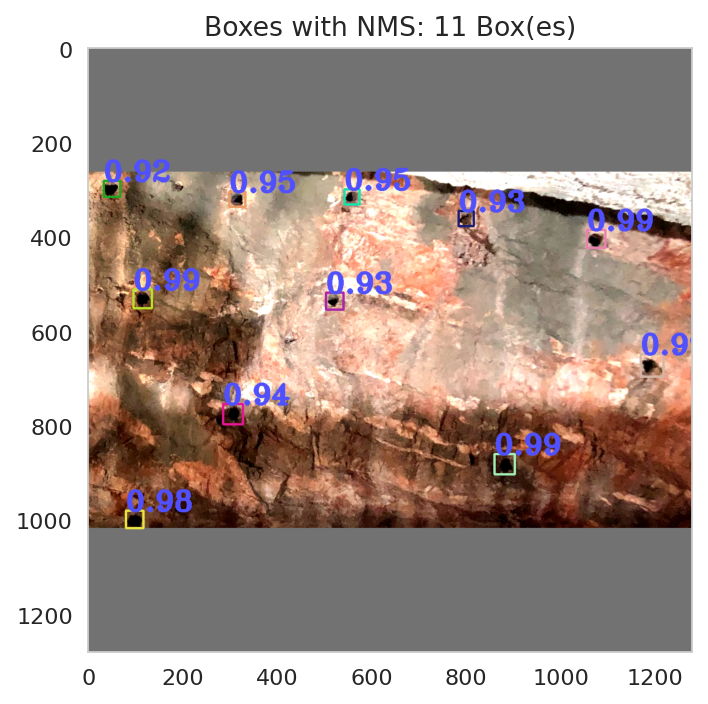

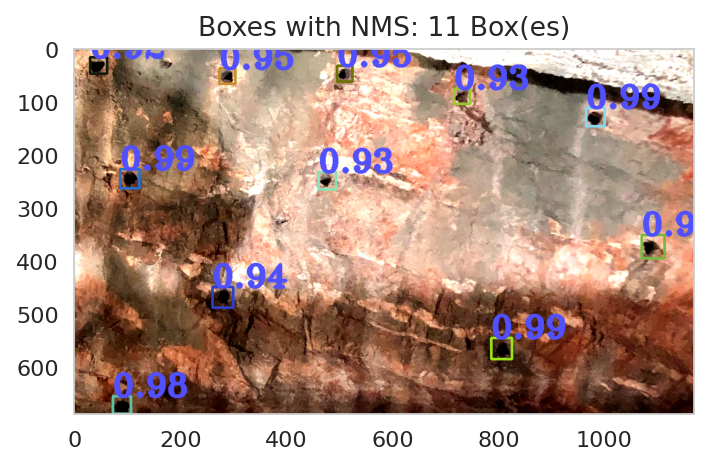

In [16]:
def clip_coords(boxes, shape):
    boxes[:, [0, 2]] = boxes[:, [0, 2]].clip(0, shape[1])  # x1, x2
    boxes[:, [1, 3]] = boxes[:, [1, 3]].clip(0, shape[0])  # y1, y2

# det[:, :4] = scale_coords(batch_inputs.shape[2:], det[:, :4], img_source.shape).round()
def my_scale_coords(img1_shape, coords, img0_shape, ratio_pad=None):
    # Rescale coords (xyxy) from img1_shape to img0_shape
    if ratio_pad is None:  # calculate from img0_shape
        gain = min(img1_shape[0] / img0_shape[0], img1_shape[1] / img0_shape[1])  # gain  = old / new
        pad = (img1_shape[1] - img0_shape[1] * gain) / 2, (img1_shape[0] - img0_shape[0] * gain) / 2  # wh padding
    else:
        gain = ratio_pad[0][0]
        pad = ratio_pad[1]

    coords[:, [0, 2]] -= pad[0]  # x padding
    coords[:, [1, 3]] -= pad[1]  # y padding
    coords[:, :4] /= gain
    clip_coords(coords, img0_shape)
    return coords

def plot_detect(prediction, batch_inputs, img_source, title=None):
    det = prediction.copy()
    det[:, :4] = my_scale_coords(batch_inputs.shape[2:], det[:, :4], img_source.shape).round()
    img_detect = img_source.copy()
    for i in det:
        x1, y1, x2, y2 = i[..., :4].round().astype(np.uint16)
        c = i[..., 4:]
        cv.rectangle(img_detect, (x1, y1), (x2, y2), color=tuple(random.randint(0,255) for _ in range(3)) , thickness=4)
        cv.putText(img_detect, f"{c[1]:.2f}", (x1,y1) ,thickness=6, color=(80, 80, 255), fontFace=cv.FONT_HERSHEY_TRIPLEX, fontScale=2)
        # cv.putText(img_detect, f"{c[0]:.0f}", (x2-40,y2-40) ,thickness=6, color=(0, 80, 255), fontFace=cv.FONT_HERSHEY_TRIPLEX, fontScale=2)
    plt.figure(figsize=(5, 5), dpi=80)
    # plot_single_image(im1)
    if title is not None:
        plt.title(title)
    plot_single_image(img_detect)

plot_detect(nms_xyxyc, batch_in, im0, title=f"Boxes with NMS: {nms_xyxyc.shape[0]} Box(es)")
plot_detect(nms_xyxyc, batch_in, img0, title=f"Boxes with NMS: {nms_xyxyc.shape[0]} Box(es)")